# Predicting flight delays 

### Technical point of view 
- visualization: matplotlib, seaborn, basemap
- data manipulation: pandas, numpy
- modeling: sklearn, scipy
- class definition: regression, figures


## Overview of the dataset
First load all the packages that will be needed during this project. 

In [1]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

read the file that contains the details of all the flights that occured in 2015. I output some informations concerning the types of the variables in the dataframe and the quantity of null values for each variable:

In [3]:
# flights data 

df_flights = pd.read_csv('../flight_data/flights.csv')
print('Dimension of flights dataframe: ', df_flights.shape)
#df_flights.head()

# gives some infos on columns types and numbers of null values
table_info= pd.DataFrame(df_flights.dtypes).T.rename(index={0: 'column type'})
table_info= table_info._append(pd.DataFrame(df_flights.isnull().sum()).T.rename(index= {0: 'number of null values'}))
table_info= table_info._append(pd.DataFrame(df_flights.isnull().sum()/df_flights.shape[0]*100).T.rename(index={0: 'null values in %'}))

table_info

Dimension of flights dataframe:  (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
number of null values,0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values in %,0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,1.480526,1.480526,1.530259,1.530259,0.000103,1.805629,1.805629,0.0,1.589822,1.589822,0.0,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


### Overview of the aiports dataset

In [4]:
aiports = pd.read_csv('../flight_data/airports.csv')
aiports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023




To have a global overview of the geographical area covered in this dataset, we can plot the airports location and indicate the number of flights recorded during year 2015 in each of them:

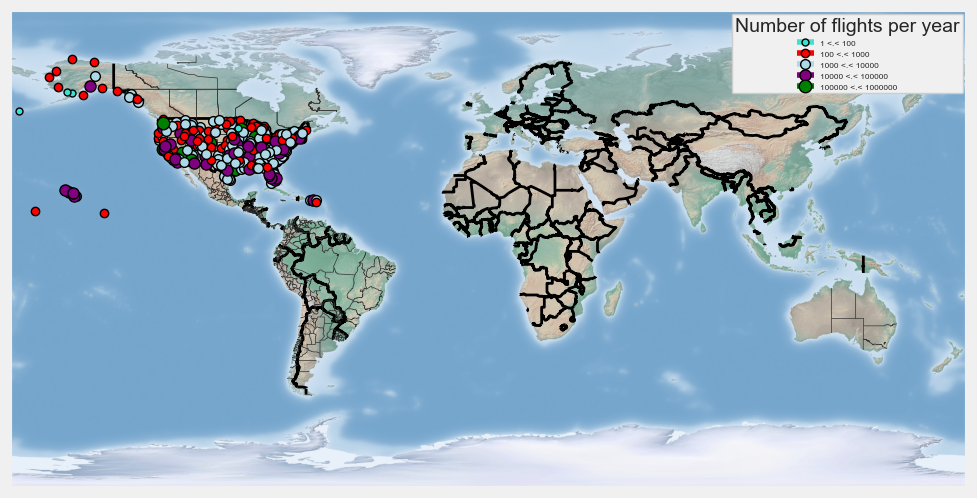

In [5]:
count_flights = df_flights['ORIGIN_AIRPORT'].value_counts()

plt.figure(figsize=(11,11))

########################################################################################################################## 
# define properties of markers and labels
colors = ['turquoise', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
########################################################################################################################## 
#resolution = 'i', install  basemap-data-hires for resolution='h' = high
map = Basemap(resolution='i', llcrnrlon=-180, urcrnrx=-50, llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0)
map.shadedrelief()
map.drawcountries(linewidth=2)
map.drawstates(color='0.2')
########################################################################################################################## 

# put airports on map

for index, (airports_code, y,x) in aiports [['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x,y = map(x,y)
    isize=[i for i, val in enumerate(size_limits) if val < count_flights[airports_code]]
    ind= isize[-1]
    # markeredgecolor: k = black, ‘b'=blue, 'g'=green, 'm'=magenta ......
    # markertypes : 'o'= circle, 'D' and 'd' diamonds 
    map.plot(x,y, marker='o', markersize=ind+5, markeredgewidth=1, color=colors[ind], markeredgecolor='k', label=labels[ind])

########################################################################################################################## 

# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size': 6},
           title='Number of flights per year', frameon = True, framealpha = 1)
plt.show()    
    


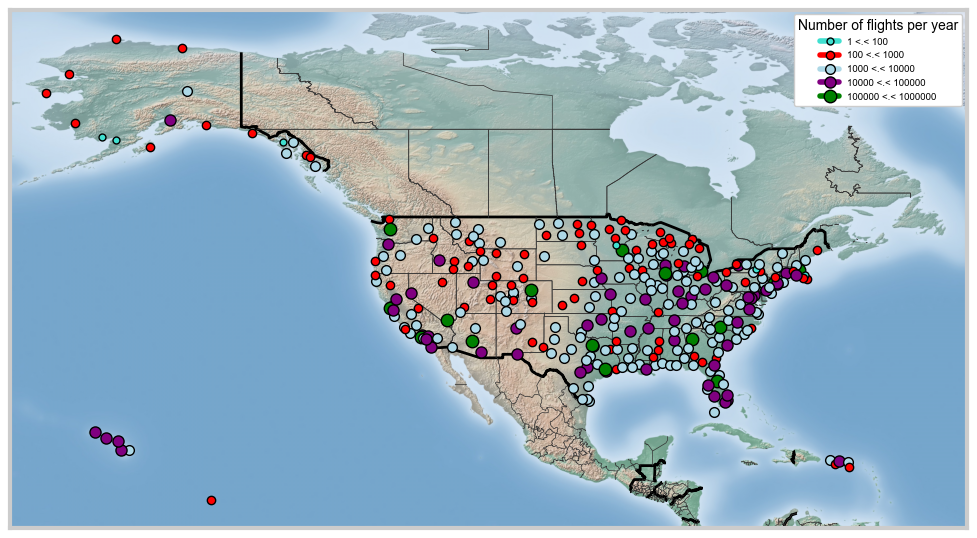

In [44]:
count_flights = df_flights['ORIGIN_AIRPORT'].value_counts()

plt.figure(figsize=(11,11))

########################################################################################################################## 
# define properties of markers and labels
colors = ['turquoise', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
########################################################################################################################## 
#resolution = 'i', install  basemap-data-hires for resolution='h' = high
map = Basemap(resolution='i', llcrnrlon=-170, urcrnrlon=-50, llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0)

map.shadedrelief()
map.drawcountries(linewidth=2)
map.drawstates(color='0.2')
########################################################################################################################## 

# put airports on map

for index, (airports_code, y,x) in aiports [['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x,y = map(x,y)
    isize=[i for i, val in enumerate(size_limits) if val < count_flights[airports_code]]
    ind= isize[-1]
    # markeredgecolor: k = black, ‘b'=blue, 'g'=green, 'm'=magenta ......
    # markertypes : 'o'= circle, 'D' and 'd' diamonds 
    map.plot(x,y, marker='o', markersize=ind+5, markeredgewidth=1, color=colors[ind], markeredgecolor='k', label=labels[ind])

########################################################################################################################## 

# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
legend = plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size': 7},
           title='Number of flights per year', frameon = True, framealpha = 1, fontsize=12, 
           title_fontsize=12)

legend.get_frame().set_facecolor('white')  # Set the legend background color to blue
legend.get_title().set_fontsize(10)  # Set the legend title size to 12
legend.get_title().set_color('black')
#legend.get_title().set_backgroundcolor('darkblue')  # Set the legend title background color to dark blue
plt.setp(legend.get_texts(), color='black')  # Set the color of the text to white

plt.show()

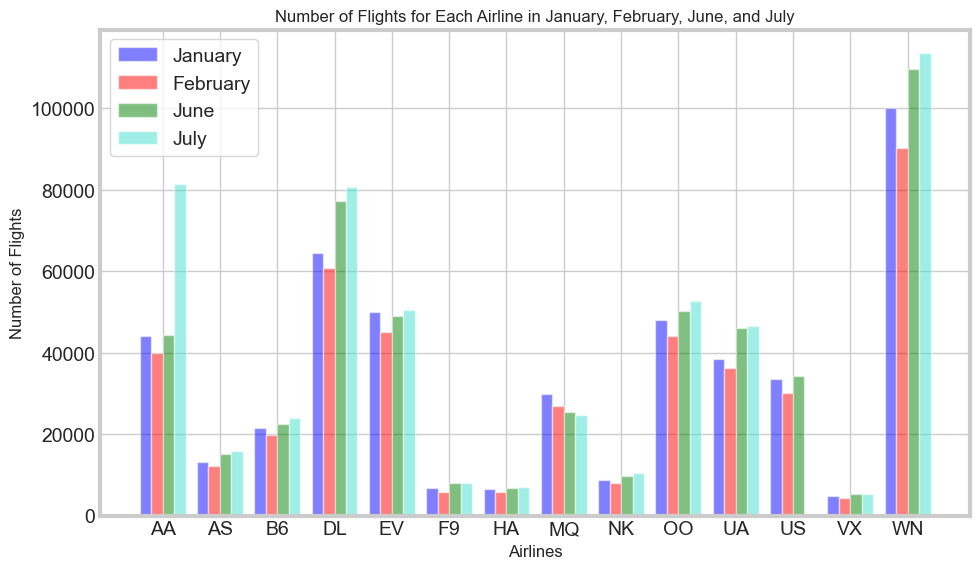

In [22]:
df_flights = pd.read_csv('../flight_data/flights.csv')

# Filter for January, February, June and July 
months_data = []
for month, month_name in zip([1, 2, 6, 7], ['January', 'February', 'June', 'July']):
    month_flights = df_flights[df_flights['MONTH'] == month]
    flights_per_airline = month_flights['AIRLINE'].value_counts()
    months_data.append(pd.DataFrame({'Airline': flights_per_airline.index, month_name: flights_per_airline.values}))

# Merge data for all months
all_data = months_data[0]
for month_data in months_data[1:]:
    all_data = pd.merge(all_data, month_data, on='Airline', how='outer')

all_data = all_data.fillna(0)  # Fill missing values with zeros

# creating the bar chart
plt.figure(figsize=(10,6))

# Define the width of the bars and the positions of the bar centers
bar_width = 0.2
r1 = np.arange(len(all_data))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot flights for each month
plt.bar(r1, all_data['January'].values, color='b', width=bar_width, alpha=0.5, label='January')
plt.bar(r2, all_data['February'].values, color='r', width=bar_width, alpha=0.5, label='February')
plt.bar(r3, all_data['June'].values, color='g', width=bar_width, alpha=0.5, label='June')
plt.bar(r4, all_data['July'].values, color='turquoise', width=bar_width, alpha=0.5, label='July')

plt.title('Number of Flights for Each Airline in January, February, June, and July',fontsize=12)
plt.xlabel('Airlines', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)

# Add xticks on the middle of the group bars
plt.xticks([r + bar_width*1.5 for r in range(len(all_data))], all_data['Airline'])

plt.legend()
plt.show()

Pie chart

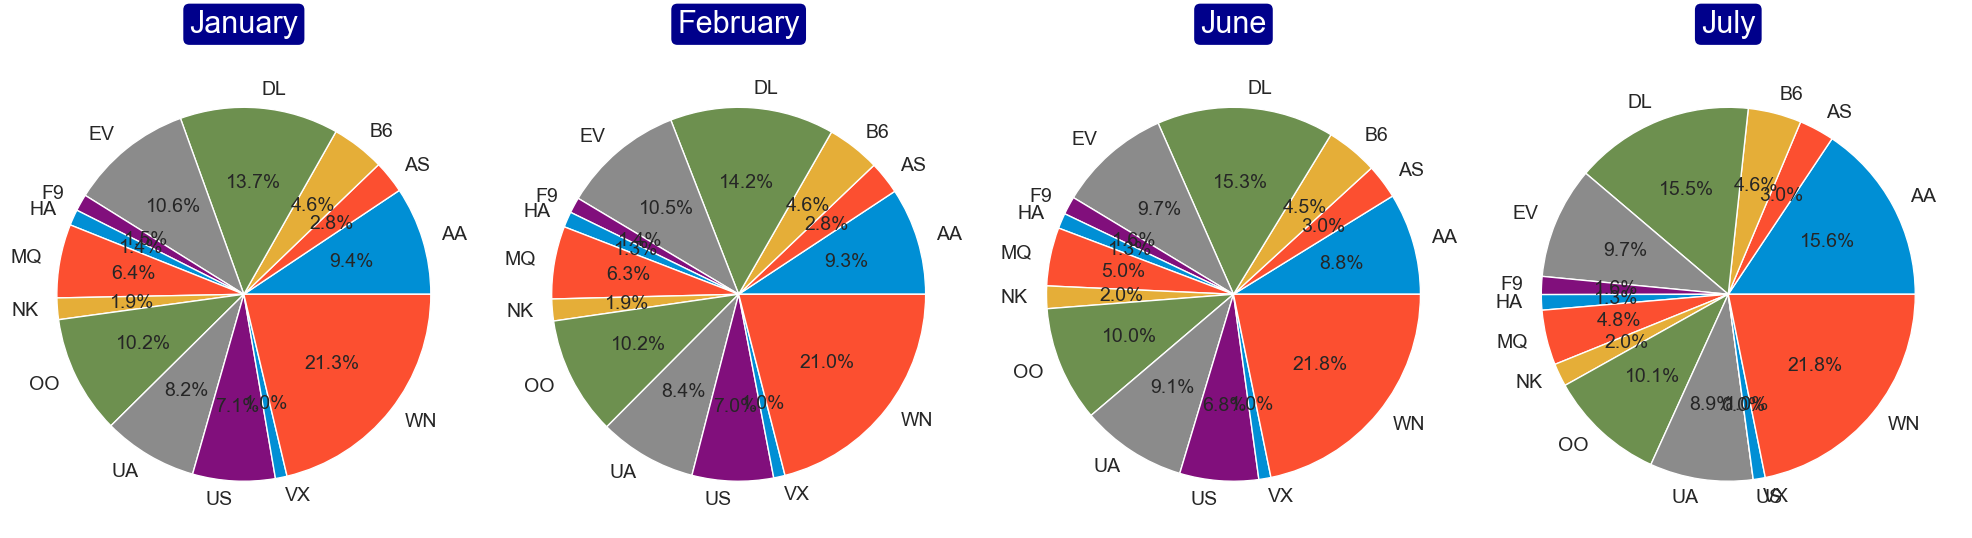

In [34]:
df_flights = pd.read_csv('../flight_data/flights.csv')

# Filter for January, February, June and July 
months_data = []
for month, month_name in zip([1, 2, 6, 7], ['January', 'February', 'June', 'July']):
    month_flights = df_flights[df_flights['MONTH'] == month]
    flights_per_airline = month_flights['AIRLINE'].value_counts()
    months_data.append(pd.DataFrame({'Airline': flights_per_airline.index, month_name: flights_per_airline.values}))

# Merge data for all months
all_data = months_data[0]
for month_data in months_data[1:]:
    all_data = pd.merge(all_data, month_data, on='Airline', how='outer')

all_data = all_data.fillna(0)  # Fill missing values with zeros

# Create a pie chart for each month
fig, axs = plt.subplots(1, 4, figsize=(20, 20))

months = ['January', 'February', 'June', 'July']
for i, ax in enumerate(axs.flat):
    ax.pie(all_data[months[i]], labels=all_data['Airline'], autopct='%1.1f%%')
    ax.set_title(months[i], fontsize=22, pad=20, color='white', bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.show()